# Learning Dynamics and Norm Psychology Supports Human Cooperation in a Large-Scale Prisoner’s Dilemma on Networks

## Initialisations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle

In [2]:
# Fixed parameters
T = 10
R = 7
P = 0
S = 0
payoffs = [[R, S],[T, P]] # actions C = 0, D = 1
n = 1000       # rounds
N = 625        # number of agents
k = 4          # number of neighbours
D_0 = 0.6      # total drive
alpha = 0.21   # memory loss
beta = 0.31    # intensity of choice
h = 0.31       # relative strength of the normative component
w_i = 3.2      # weights
w_c = 1
w_0 = 0.33

## Utils

In [3]:
def getNeighbours(N,row,col):
    # return contains neighbours in order [Up, Right, Down, Left]
    if row == 0:
        if col == 0:
            return [(N-1, col), (row, col+1), (row+1, col), (row, N-1)]
        elif col == N-1:
            return [(N-1, col), (row, 0), (row+1, col), (row, col-1)]
        else:
            return [(N-1, col), (row, col+1), (row+1, col), (row, col-1)]
    elif row == N-1:
        if col == 0:
            return [(row-1, col), (row, col+1), (0, col), (row, N-1)]
        elif col == N-1:
            return [(row-1, col), (row, 0), (0, col), (row, col-1)]
        else:
            return [(row-1, col), (row, col+1), (0, col), (row, col-1)]
    else: 
        return [(row-1, col), (row, col+1), (row+1, col), (row, col-1)]

In [4]:
def selectActions(m, A, p):
    for i in range(m):
        for j in range(m):
            A[i*m+j] = 0 if np.random.random() <= p else 1 
    return

In [5]:
def updateActions(m, A, P_tp1):
    for i in range(m):
        for j in range(m):
            A[i * m + j] = 0 if np.random.random() <= P_tp1[i * m + j] else 1 
    return 

In [6]:
def getObservedCooperation(m, neighbours, A):
    count = 0
    for (ni,nj) in neighbours:
        if A[ni*m+nj] == 0:
            count += 1
    return count

In [7]:
def computeIndividualDrive(m, neighbours, A):
    sum_diff = 0.0
    for (ni,nj) in neighbours:
        rew_C = payoffs[0][A[ni*m+nj]]
        rew_D = payoffs[1][A[ni*m+nj]]
        sum_diff += (rew_C - rew_D)
    return sum_diff / 4.0

In [8]:
def updateParameters(m, A_tm1, dN, dI, D_tp1, P_tp1):
    for i in range(m):
        for j in range(m):
            # get neighbours of agent at position (i,j)
            neighbours = getNeighbours(m, i, j) 
            # ct = 1 if agent cooperated, else 0
            ct = int(A_tm1[i * m + j] == 0)
            # get previous neighbour cooperation count
            Ot = getObservedCooperation(m, neighbours, A_tm1)
            # get previous D
            Dt = D_tp1[i * m + j]
            # compute dN
            dNt = w_c * (2 * ct - 1) + w_0 * Ot + w_i * ct * Ot
            # compute dI
            dIt = computeIndividualDrive(m, neighbours, A_tm1)
            # compute new D_tp1
            Dtp1 = (1.0 - alpha) * Dt + dIt + h * dNt
            # compute cooperation probability
            Ptp1 = 1.0 / (1.0 + math.exp(-beta * Dtp1))
            # update variables
            dN[i * m + j] = dNt
            dI[i * m + j] = dIt
            D_tp1[i * m + j] = Dtp1
            P_tp1[i * m + j] = Ptp1 
    return

In [9]:
def shuffle(lists):
    start_state = np.random.get_state()
    for a in lists:
        np.random.shuffle(a)
        np.random.set_state(start_state)
    return

## Static Lattice Simulation

In [10]:
# Containers for parameters of the game            
A_stat = np.zeros(N, dtype=int)    # array of actions for the N players over the n rounds
dI_stat = np.zeros((N,n))          # array to store the individual drive for each player in each round
dN_stat = np.zeros((N,n))          # array to store the norm salience for each player in each round
cooperation_stat = np.zeros(n)     # counter for the cooperation over time
D_tp1_stat = np.add(D_0,np.zeros(N))    # array to store the drive, initialised to D_0
P_tp1_stat = np.zeros(N)                # array to store the cooperation probability for each player

for t in range(n):
    if t == 0 :
        # select initial action for each agent
        selectActions(25, A_stat, D_0) 
    else:  
        # update actions for each agent
        updateActions(25, A_stat, P_tp1_stat) 
    # count cooperation
    cooperation_stat[t] = (N - sum(A_stat))/N
    # update parameters for each agent
    updateParameters(25, A_stat, dN_stat[:,t], dI_stat[:, t], D_tp1_stat, P_tp1_stat)

## Dynamic lattice simulation

In [11]:
# Containers for parameters of the game            
A_dyn = np.zeros(N, dtype=int)    # array of actions for the N players over the n rounds
dI_dyn = np.zeros((N,n))          # array to store the individual drive for each player in each round
dN_dyn = np.zeros((N,n))          # array to store the norm salience for each player in each round
cooperation_dyn = np.zeros(n)     # counter for the cooperation over time
D_tp1_dyn = np.add(D_0,np.zeros(N))    # array to store the drive, initialised to D_0
P_tp1_dyn = np.zeros(N)                # array to store the cooperation probability for each player

for t in range(n):
    if t == 0 :
        # select initial action for each agent
        selectActions(25, A_dyn, D_0) 
    else:  
        # re-shuffle players
        shuffle([A_dyn, D_tp1_dyn, P_tp1_dyn])
        # update actions for each agent
        updateActions(25, A_dyn, P_tp1_dyn) 
    # count cooperation
    cooperation_dyn[t] = (N - sum(A_dyn))/N
    # update parameters for each agent
    updateParameters(25, A_dyn, dN_dyn[:,t], dI_dyn[:, t], D_tp1_dyn, P_tp1_dyn)

## Random network simulation

In [12]:
def softmax(x, b):
    return 1 / (1 + math.e**(-b * x))

In [13]:
def generate_net():
    """Generates a network with N nodes, each having k neighbours
    """
    strats = [0, 1]
    drive = np.full((N,), 0.6, dtype=np.float64)
    pop = np.random.choice(strats, size=N, replace=True, p=[D_0, 1-D_0])
    adjmat = np.empty((N,), dtype=object)
    for i in range(adjmat.size):
        adjmat[i] = []

    for i, adj in np.ndenumerate(adjmat[:-1]):
        if len(adj) < k:
            sample = np.random.randint(i[0] + 1, N, size=k-len(adj))
            # while the sample isn't valid, i.e. has duplicates or full neighbourhood's players, retry 
            while not len(sample) == len(set(sample)) and all(len(adjmat[other]) < k for other in sample):
                sample = np.random.randint(i[0] + 1, N, size=k-len(adj))
            adj.extend(sample)
            for other in sample:
                adjmat[other].append(i[0])

    return pop, drive, adjmat

In [14]:
def simulate_play(index, pop, adjmat, val="C"):
    """Simulates the score of an agent at index if he were to play val in the current settings.
    """
    score = 0
    for other in adjmat[index]:
        score += payoffs[val][pop[other]]
    return score

In [15]:
def update(pop, drive, adjmat, dI, dN, it):
    updated_pop = np.empty_like(pop)
    for i in range(pop.size):
        Ot = sum([pop[j] == 0 for j in adjmat[i]])
        ct = int(pop[i] == 0)
        dnt = w_c * (2 * ct - 1) + w_0 * Ot + w_i * ct * Ot
        dN[i, it] = dnt
        dit = simulate_play(i, pop, adjmat, val=0) - simulate_play(i, pop, adjmat, val=1)
        dit /= 4
        dI[i, it] = dit
        drive[i] = drive[i] * (1 - alpha) + dit + h * dnt
        if np.random.random() < softmax(drive[i], beta):
            updated_pop[i] = 0
        else:
            updated_pop[i] = 1
    return updated_pop

In [16]:
cooperation_rand = np.zeros(n)
pop, drive, adjmat = generate_net()
cooperation_rand[0] = (N - sum(pop))/N
dI_rand = np.zeros((N,n))                      # array to store the individual drive for each player
dN_rand = np.zeros((N,n))                      # array to store the norm salience for each player

for i in range(pop.size):
    Ot = sum([pop[j] == 0 for j in adjmat[i]])
    ct = int(pop[i] == 0)
    dnt = w_c * (2 * ct - 1) + w_0 * Ot + w_i * ct * Ot
    dN_rand[i, 0] = dnt
    dit = simulate_play(i, pop, adjmat, val=0) - simulate_play(i, pop, adjmat, val=1)
    dit /= 4
    dI_rand[i, 0] = dit
    drive[i] = drive[i] * (1 - alpha) + dit + h * dnt
    
for t in range(1, n):
    pop = update(pop, drive, adjmat, dI_rand, dN_rand, t)
    cooperation_rand[t] = (N - sum(pop))/N

P_tp1_rand = softmax(drive, beta)

## Plots

### Fraction of agents that cooperated in each round of the game 

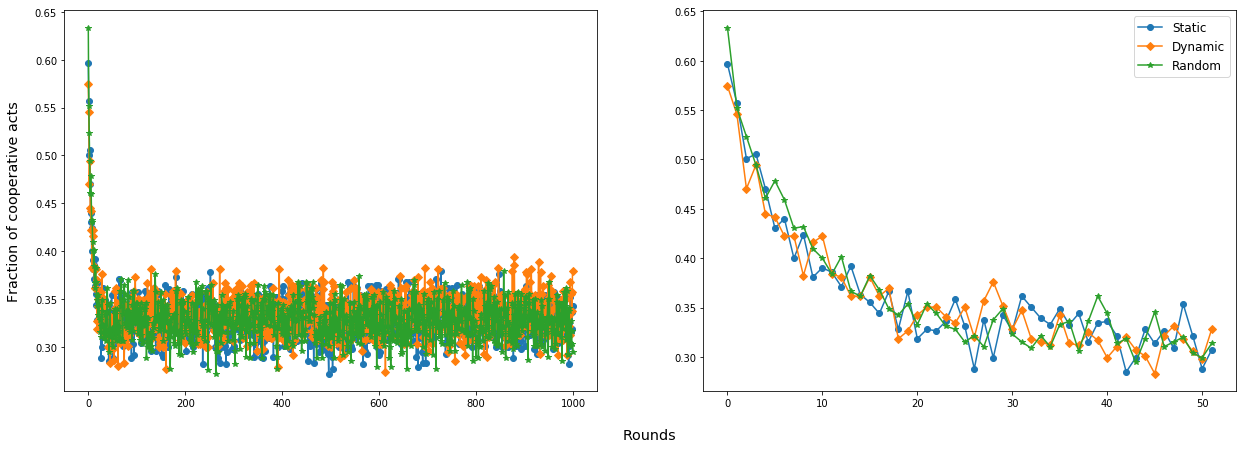

In [17]:
# create figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(21,7))

# plot the cooperation level
time = np.arange(n)
ax1.plot(time, cooperation_stat, marker = "o", label='Static')
ax1.plot(time, cooperation_dyn, marker = "D", label='Dynamic')
ax1.plot(time, cooperation_rand, marker = "*", label='Random')

ax2.plot(time[0:52], cooperation_stat[0:52], marker = "o", label='Static')
ax2.plot(time[0:52], cooperation_dyn[0:52], marker = "D", label='Dynamic')
ax2.plot(time[0:52], cooperation_rand[0:52], marker = "*", label='Random')
ax2.legend(fontsize='large')

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)

# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Rounds', fontsize='x-large', labelpad=20)
plt.ylabel('Fraction of cooperative acts', fontsize='x-large', labelpad=20)

plt.show()
fig.savefig('plots/cooperation.png')

### Fraction of agents that reached a certain probability of cooperation 

In [18]:
def myHist(bins, P):
    ys = [0 for _ in bins]
    for i, val in enumerate(bins):
        for p in P:
            if p >= val - 0.05 and p < val + 0.05:
                ys[i] += 1
    res = [float(ysi)/N for ysi in ys]
    return res

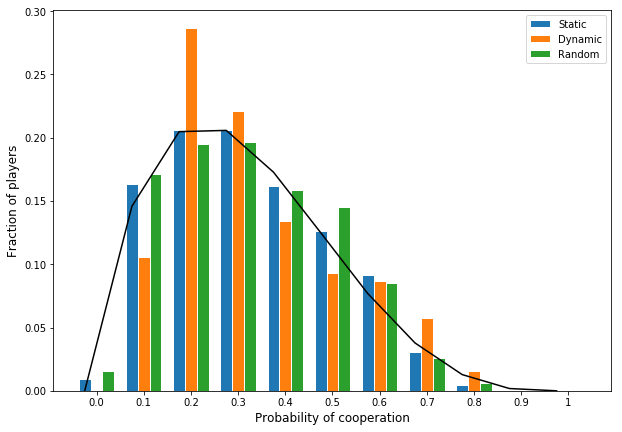

In [19]:
# Compute bar heights
xs = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
mu = [2*x*((1-x)**3) for x in xs]
bars1 = myHist(xs, P_tp1_stat)
bars2 = myHist(xs, P_tp1_dyn)
bars3 = myHist(xs, P_tp1_rand)

# Set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(xs))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(r1, bars1, width=barWidth, edgecolor='white', label='Static')
ax.bar(r2, bars2, width=barWidth, edgecolor='white', label='Dynamic')
ax.bar(r3, bars3, width=barWidth, edgecolor='white', label='Random')
ax.plot(r1, mu, c='k')

# Add xticks on the middle of the group bars
plt.xlabel('Probability of cooperation', fontsize='large')
plt.ylabel('Fraction of players', fontsize='large')
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
 
# Create legend & Show graphic
plt.legend()
plt.show()

fig.savefig('plots/prob_cooperation.png')

### Probability for a generic agent to cooperate after she cooperated or after she defected

### Stationary state: Probability of agents who reached a given probability of cooperation, a certain individual drive and a given normative drive

In [20]:
def plotStationaryState(P, dI, dN, filename):
    # create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True, figsize=(21,7))

    # plot the cooperation level
    bins = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    bars = myHist(bins, P)    
    r = np.arange(len(bins))
    ax1.bar(r, bars, width = 0.5, color='#0504aa',alpha=0.7)
    ax1.set_xticklabels(xs)
    ax1.set_xlabel('Probability of cooperation', fontsize='large')
    ax1.set_ylabel('Fraction of players', fontsize='large')
    ax1.set_ylim(0,1)
    
    # plot the individual drive
    hist,bin_edges = np.histogram(dI, bins = 5)
    ax2.bar(bin_edges[:-1], np.divide(hist,N), width = 0.5, color='#0504aa',alpha=0.7)
    ax2.set_xlabel('Individual drive', fontsize='large')
    ax2.set_ylabel('Fraction of players', fontsize='large')
    ax2.set_xlim(-16,0)
    
    # plot the normative drive
    hist,bin_edges = np.histogram(dN, bins = 5)
    ax3.bar(bin_edges[:-1], np.divide(hist,N), width = 0.5, color='#0504aa',alpha=0.7)
    ax3.set_xlabel('Normative drive', fontsize='large')
    ax3.set_ylabel('Fraction of players', fontsize='large')
    ax3.set_xlim(-5,30)

    plt.show()
    fig.savefig(filename)

*** Static lattice ***


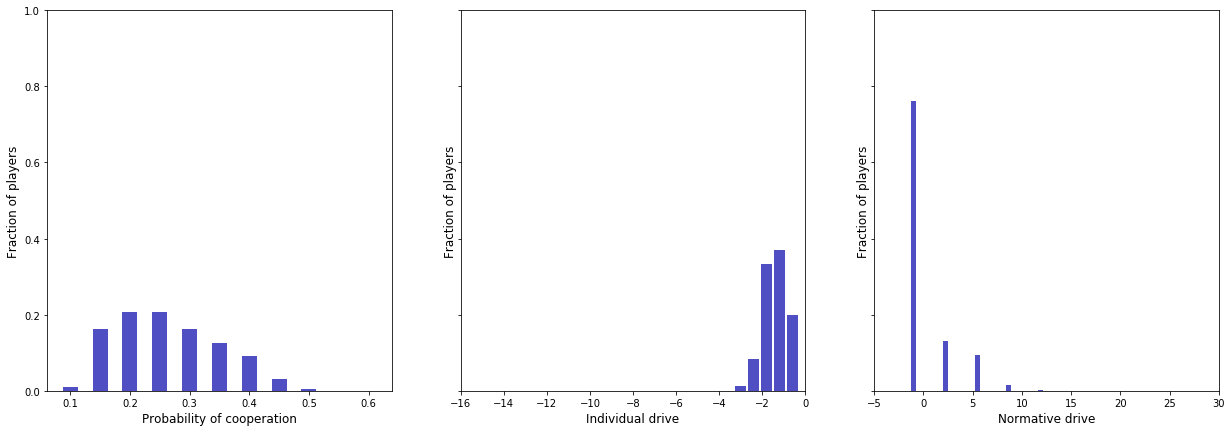

*** Dynamic lattice ***


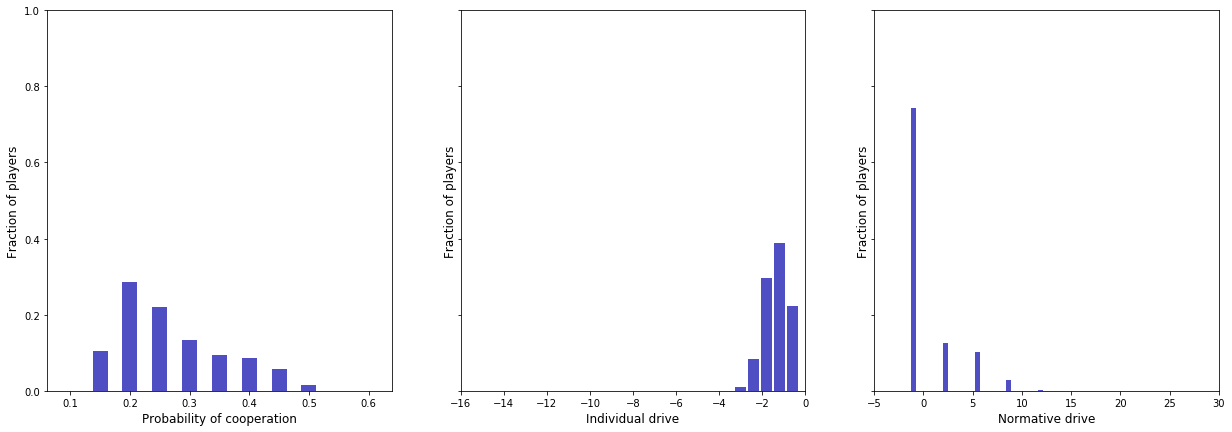

*** Random network ***


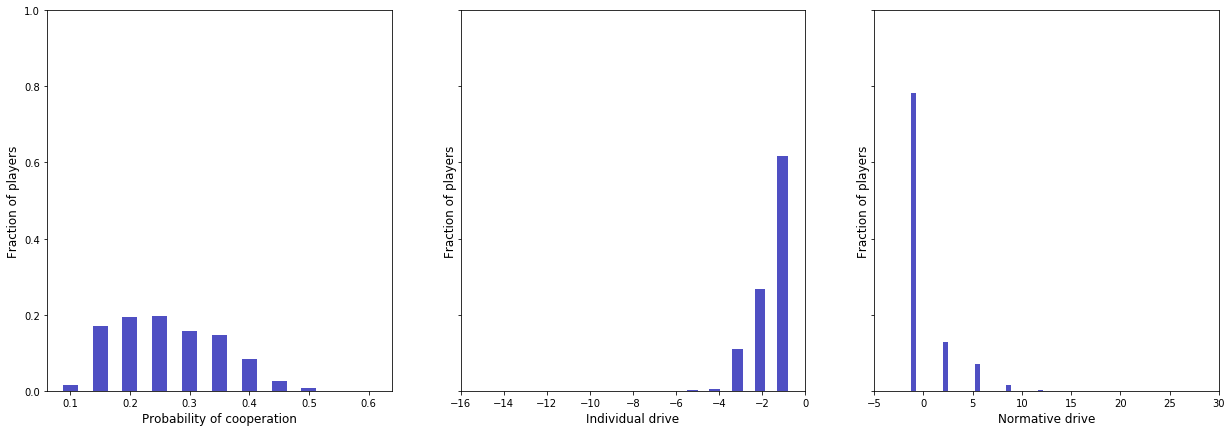

In [21]:
stat = 52

# plot for static lattice treatment
print('*** Static lattice ***')
plotStationaryState(P_tp1_stat, dI_stat[:, stat], dN_stat[:, stat], 'plots/stationary_static.png')

# plot for dynamic lattice treatment
print('*** Dynamic lattice ***')
plotStationaryState(P_tp1_dyn, dI_dyn[:, stat], dN_dyn[:, stat], 'plots/stationary_dyn.png')

# plot for random network treatment
print('*** Random network ***')
plotStationaryState(P_tp1_rand, dI_rand[:, stat], dN_rand[:, stat], 'plots/stationary_rand.png')